# <p style="background-color:skyblue; font-family:newtimeroman; font-size:160%; text-align:center">Tabular Playground Series April</p>
1. [Exploratory Data Analysis 📊](https://www.kaggle.com/zhaodianwen/tps-april-1-eda/)
2. [Data Pre-processing 📝](https://www.kaggle.com/zhaodianwen/tps-april-2-data-pre-processing/)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno  #show the nerd data in the dataframe 

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Pre-processing 📝

In [ ]:
###To continue with previous EDA
##loading data
train = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')
sample_submission = pd.read_csv('../input/tabular-playground-series-apr-2021/sample_submission.csv')

## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_indexs = train.index
test_indexs = test.index

df = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
df = df.drop('PassengerId', axis=1)

## Collecting all the features. 
feature_cols = train.drop(['PassengerId', 'Survived'], axis=1).columns

## Getting all the data that are not of "object" type. 
numerical_columns = train[feature_cols].select_dtypes(include=['int64','float64']).columns
categorical_columns = train[feature_cols].select_dtypes(exclude=['int64','float64']).columns

## Deal with missing values:

Infomation about missing values in train&test data:

In [ ]:
print('N. of missing values in train data:')
print('------')
print(train.isnull().sum())

In [ ]:
print('N. of missing values in test data:')
print('------')
print(test.isnull().sum())

Infomation about missing values in the whole dataset:

In [ ]:
for col in df.columns:
    wsg = 'column: {:>10} -> Percent of NaN value: {:.2f}%'.format(col, 100*(df[col].isnull().sum()/df[col].shape[0]))
    print(wsg)

In [ ]:
#.iloc[] = index location. it brings the index that we need (distribution)
#the blank below the graph is the null
msno.matrix(df=df.iloc[:, :],figsize=(14,14),color=(0.4,0.4,0.4))

In [ ]:
#Other way to find null data - using bar (percentage)
msno.bar(df=df.iloc[:, :],figsize=(14,14),color=(0.4,0.4,0.4))

Some insights:

1. find out 'Embarked', 'Fare' should be okay with their missing values.
1. find out 'Carbin', 'Ticket', 'Age' should be carefully deal with.
1. let's check the distribution of features with missing values: 

# Feature Engineering 🔧

fillna

In [ ]:
##1.
##Embarked : C = Cherbourg, Q = Queenstown, S = Southampton 
##Most of the passenger embarked from Southampton and over 50k didn't survive.
test['Embarked'].fillna((train['Embarked'].mode()), inplace=True)
train['Embarked'].fillna((train['Embarked'].mode()), inplace=True)

test['Fare'].fillna((train['Fare'].mean()), inplace=True)
train['Fare'].fillna((train['Fare'].mean()), inplace=True)

##2.

test['Age'].fillna((train['Age'].median()), inplace=True)
train['Age'].fillna((train['Age'].median()), inplace=True)

Fare is a boarding fee and a constant feature. I'll draw a histogram.

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(14,14))
g = sns.distplot(df['Fare'], color='b',label='skewness : {:.2f}'.format(df['Fare'].skew(), ax=ax))
g = g.legend(loc='best')

the distribution is very asymmetrical (high sense), too sensitive to a few outliers.
To reduce the impact of outlier, we should log on Fare.


In [ ]:
##Here we will use the useful function of Pandas -- map(). If you want to apply a common action lambda function to a particular column of dataFrame, you can apply it very easily by using the map, or apply below. What we want now is to log all the data in the 'Fare' column, and if you put a simple lambda function that applies a simple log into the map(), it's applied to the 'Fare' columns data!

train['Fare'] = train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
test['Fare'] = test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
g = sns.distplot(train['Fare'], color='b', label='Skewness : {:.2f}'.format(train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

combine the number of SibSp & Parch +1 to be FamilySize, a new feature synthesized:

In [ ]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1 #we have to add 1 because we have include oneself
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1 #we have to add 1 because we have include oneself

family_ratio = train.groupby('FamilySize')['Survived'].mean() * 100
print('Maximum size of FamilySize:', train['FamilySize'].max())
print('Minimum size of FamilySize:', train['FamilySize'].min())
print(family_ratio)

## Encodeing Categorical Columns:
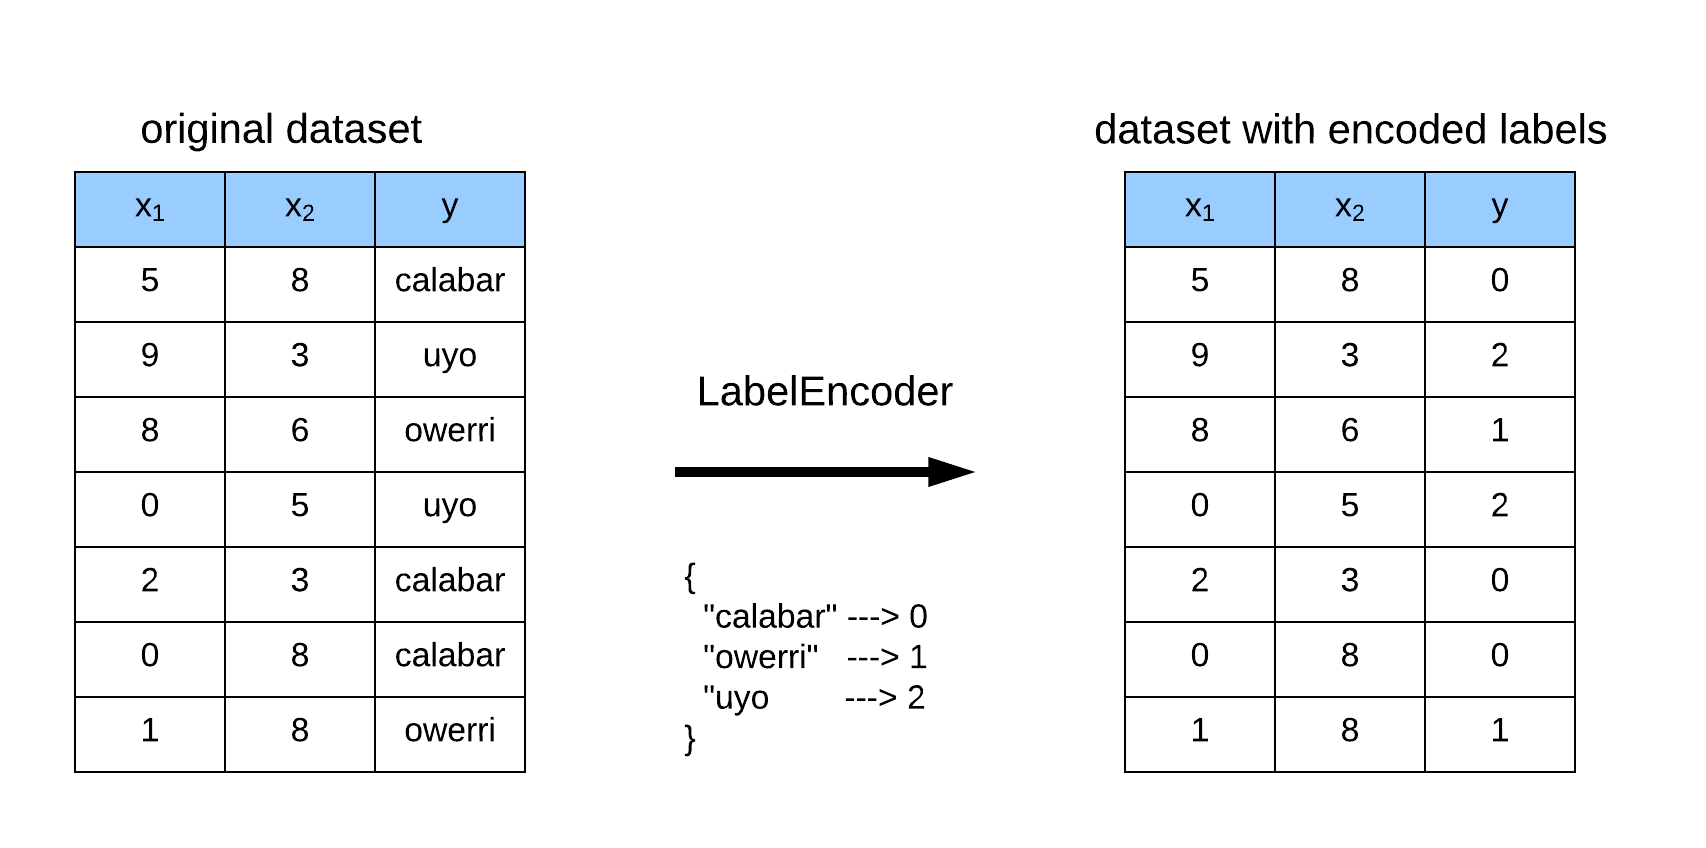

In [ ]:
# ##manual encoder:
# train['Sex'] = 1*(train['Sex'] == 'male')
# test['Sex'] = 1*(test['Sex'] == 'male')

In [ ]:
# Dropping unimportant columns:
train.drop(['Name','Ticket','Cabin'], axis=1, inplace=True)
test.drop(['Name','Ticket','Cabin'], axis=1, inplace=True)

##Applying Label Encoder:
obj_cols = train.select_dtypes(include=['object']).columns.tolist()
for col in obj_cols:
    le = LabelEncoder()
    le.fit(train[col])
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])

In [ ]:
train.head()

In [ ]:
test.head()